In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, odeint
from scipy.signal import TransferFunction, lsim, tf2ss

import scipy
import os
import control

SAVE_PATH = 'report/figs/'
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
plt.rcParams['figure.figsize'] = [4, 4]

In [2]:
# var 17
a_1, a_0 = 2, 4
b_1, b_0 = 3, 5
k_1, k_0 = 4, 4
g = lambda t : np.sin(t) + 0.5 * np.cos(2 * t) 

# Task 1

In [3]:
theta = np.array([k_0 - a_0, k_1 - a_1, b_0, b_1])

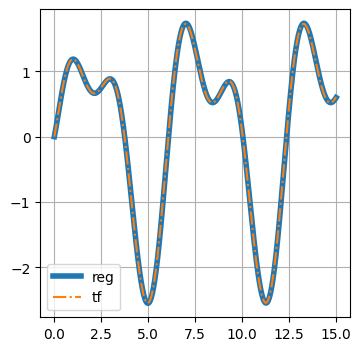

In [274]:
class OutputParametrization():
    def __init__(self, denum_ks, n, m, y0, u0, theta) -> None:
        u0 = np.array([u0])
        parts = y0 / sum(theta**2)
        self.n = n
        self.m = m
        self.num = [1]
        self.denum_ks = denum_ks
        self.omega = [tf2ss(self.num + [0] * i, denum_ks) for i in range(n)]
        self.omega += [tf2ss(self.num + [0] * i, denum_ks) for i in range(m)]
        self.systems_xs = []
        self.y = np.array([y0]).reshape(1, 1)
        parts = np.array([parts]).reshape(1, 1)
        for i in range(self.n):
            A, B, C, D = self.omega[i]
            x0 = np.linalg.pinv(C) @ (parts * theta[i] - D * u0)
            self.systems_xs.append(x0)
        for i in range(self.n, self.n + self.m):
            A, B, C, D = self.omega[i]
            x0 = np.linalg.pinv(C) @ (parts * theta[i] - D * u0)
            self.systems_xs.append(x0)
    
    def model(self, ts, us, theta):
        ys = np.zeros(self.m + self.n)
        dt = ts[1] - ts[0]
        res = [self.y.reshape(-1)[-1]]
        for idx in range(len(ts) - 1):
            for i in range(self.n):
                A, B, C, D = self.omega[i]
                A, B, C, D, _ = scipy.signal.cont2discrete((A, B, C, D), dt)
                self.systems_xs[i] = A @ self.systems_xs[i] + B * self.y
                ys[i] = (C @ self.systems_xs[i] + D @ self.y).reshape(-1)[-1]
            for i in range(self.n, self.n + self.m):
                A, B, C, D = self.omega[i]
                A, B, C, D, _ = scipy.signal.cont2discrete((A, B, C, D), dt)
                self.systems_xs[i] = A @ self.systems_xs[i] + B * us[idx]
                ys[i] = (C @ self.systems_xs[i] + D * u[idx]).reshape(-1)[-1]
            res.append(theta.T @ ys)
            self.y = np.array(res[-1]).reshape(1, 1)
        return res

ts = np.linspace(0, 15, 1000)
u = g(ts).reshape((len(ts), 1))

y0 = 0
ov = OutputParametrization(denum_ks=[1, k_1, k_0], n=2, m=2, y0=y0, u0=u[0], theta=theta)
res = ov.model(ts, u, theta)
plt.plot(ts, res, label='reg', linewidth=4)

sptf = TransferFunction([b_1, b_0], [1, a_1, a_0])
A, B, C, D = tf2ss([b_1, b_0], [1, a_1, a_0])
x0 = np.linalg.pinv(C) @ (np.array([y0]) - D * 1)
t, y, x = lsim(sptf, U=u, T=ts, X0=x0.reshape(-1))
plt.plot(t, y, '-.', label='tf')
plt.legend()
plt.grid()
plt.savefig(SAVE_PATH + '1_output_reg.png')

# Task 2

In [253]:
ssA_orig = np.array([[-a_1, 1], [-a_0, 0]])
A_0 = np.array([[-k_1, 1], [-k_0, 0]]) 
ssB_orig = np.array([b_1, b_0]).reshape((A.shape[0], 1))
ssC_orig = np.zeros(ssA_orig.shape[0])
ssC_orig[0] = 1
ssD_orig = np.zeros((1, ssB_orig.shape[1]))

ss_orig = control.ss(ssA_orig, ssB_orig, ssC_orig, ssD_orig)
ssA_orig, ssB_orig, ssC_orig, ssD_orig = ss_orig.A, ss_orig.B, ss_orig.C, ss_orig.D
ss = control.reachable_form(ss_orig)[0]
reach2orig = control.reachable_form(ss)[1]
ssA, ssB, ssC, ssD = ss.A, ss.B, ss.C, ss.D

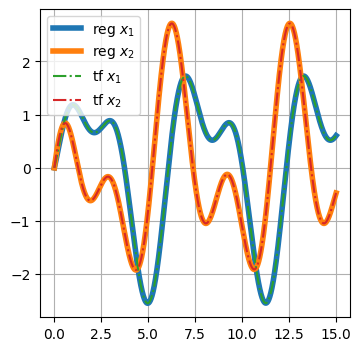

In [271]:
import sympy
from sympy.abc import s

class StateParametrization():
    def __init__(self, theta, A_0, C, dt, x0=None) -> None:
        # self.filters = np.zeros((A_0.shape), dtype=object)
        # tfs = (sympy.Matrix(np.eye(A_0.shape[0])) * s - sympy.Matrix(A_0)).inv()
        # for i in range(len(tfs)):
        #     tf = tfs[i]
        #     # print('====')
        #     # print(tf)
        #     tf = sympy.fraction(tf)
        #     if type(tf[0]) is not sympy.core.numbers.Integer:
        #         num = sympy.poly(tf[0]).all_coeffs()
        #     else:
        #         num = [tf[0]]
        #     denum = sympy.poly(tf[1]).all_coeffs()
        #     num = list(map(float, num))
        #     denum = list(map(float, denum))
        #     # print(num)
        #     # print(denum)
        #     # print(TransferFunction(num, denum))
        #     self.filters[i // A.shape[0], i % A.shape[0]] = TransferFunction(num, denum)
        # self.filters = np.array((self.filters, self.filters))
        # print(tfs)
        # print(self.filters.shape)
        # B = np.zeros((A_0.shape[0], 1))
        # B[1, 0] = 1
        # A, B, C, D, _ = scipy.signal.cont2discrete((A_0, B, np.eye(A_0.shape[0]), np.zeros((A_0.shape[0], 1))), dt)
        # print(A, B)
        self.C = C
        self.n = A_0.shape[0]
        self.dt = dt
        self.A_0 = A_0
        self.theta = theta
        sum_theta = np.sum(theta**2)
        self.states = np.zeros((self.n * 2, 2))
        if type(x0) is not None:
            for i in range(len(theta)):
                self.states[i] = (x0 / sum_theta) * theta[i]
        # print(theta @ self.states)

    def model(self, ts, us, theta):
        res = [self.theta @ self.states]
        for idx in range(len(ts) - 1):
            y = (self.C @ res[-1]).reshape(-1)[-1]
            for i in range(self.n):
                e = np.zeros((self.n, 1))
                e[self.n - i - 1] = 1
                A, B, C, D, _ = scipy.signal.cont2discrete((self.A_0, e, np.eye(self.n), np.zeros((self.n, 1))), self.dt)
                self.states[i] = A @ self.states[i] + (B * y).reshape(-1)
            for i in range(self.n):
                e = np.zeros((self.n, 1))
                e[self.n - i - 1] = 1
                A, B, C, D, _ = scipy.signal.cont2discrete((self.A_0, e, np.eye(self.n), np.zeros((self.n, 1))), self.dt)
                self.states[self.n + i] = A @ self.states[self.n + i] + (B * us[idx]).reshape(-1)
            res.append(theta @ self.states)
        return res
        

t_max = 15
dt = 1e-3
ts = np.linspace(0, t_max, int(t_max / dt))
u = g(ts).reshape((len(ts), 1))

ov = StateParametrization(theta, A_0, ssC_orig, dt=ts[1]-ts[0], x0=np.array([0, 0]))
res = ov.model(ts, u, theta)
plt.plot(ts, res, label=['reg $x_1$', 'reg $x_2$'], linewidth=4)

t, y, x_orig = lsim((ssA_orig, ssB_orig, ssC_orig, ssD_orig), U=u, T=ts)
plt.plot(t, x_orig, '-.', label=['tf $x_1$', 'tf $x_2$'])
plt.grid()
plt.legend()
plt.savefig(SAVE_PATH + '2_state_reg.png')

# Task3